In [515]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_gen_module import moffat, sersic
from src.analysis_module import gaussian_weight, wiener_deconvolution
from scipy.ndimage import shift
import matplotlib as mpl
from photutils.segmentation import detect_threshold, detect_sources
from photutils.centroids import centroid_com
from photutils.segmentation import deblend_sources
from scipy.spatial import cKDTree
from scipy.stats import norm

In [432]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.edgecolor'] = 'none'
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False

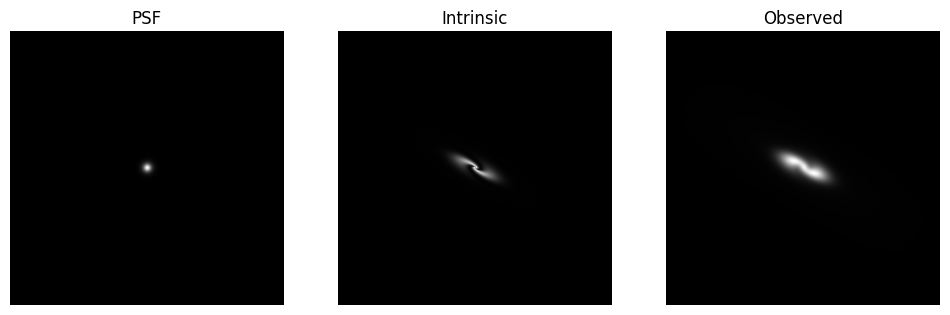

In [433]:
width = 400
height = 400

# Create PSF and Galaxy images
image_psf = moffat(width, height, 3.5, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [434]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 15, 15)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:3f}')

# Calculate the rescaled weight function
weight_rescale = wiener_deconvolution(weight, image_psf, 0)

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F = np.sum(weight_rescale * image)
print(f'The aperture flux using the observed image and rescaled weight function{measured_F:.3f}')

The aperture flux measured using the intrinsic image and weight function : 0.339277
The aperture flux using the observed image and rescaled weight function0.338


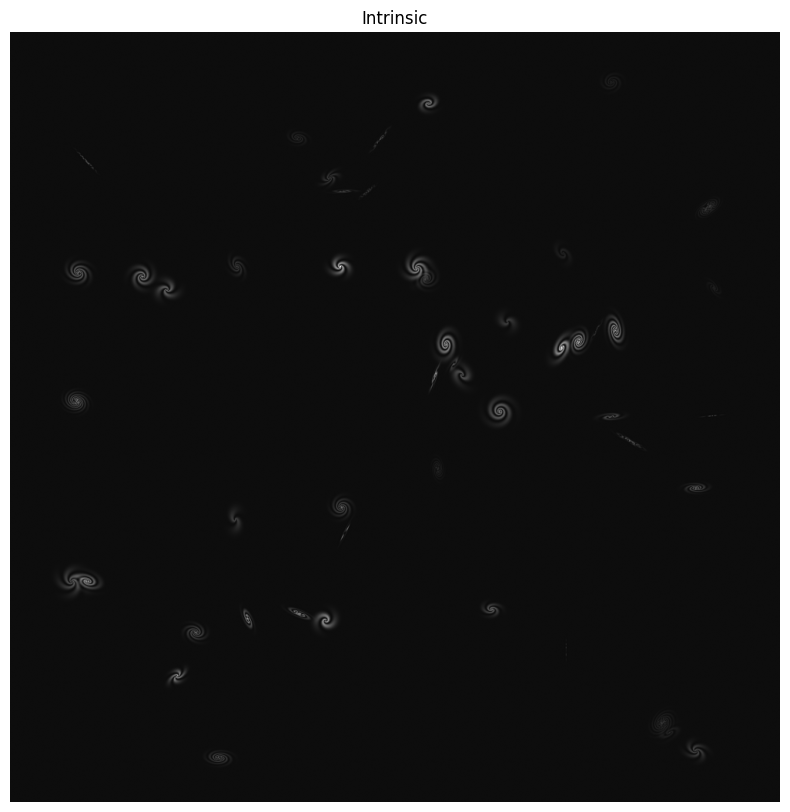

In [513]:
N_galaxies = 50
height = 1000
width = 1000
margin = 50

# Define scaling for the weight
a = 6
b = 6

image = np.zeros((height, width), dtype=float)

centers = []
true_F = []
for _ in range(N_galaxies):
    # Generate random galaxy parameters
    xc = np.random.uniform(0 + margin, width - margin)
    yc = np.random.uniform(0 + margin, height - margin)
    k = np.random.uniform(1e-3, 1)
    n = np.random.uniform(0.2, 0.5)
    rotation = np.random.uniform(-np.pi / 2, np.pi / 2)
    inclination = np.random.uniform(0.1, np.pi / 2)
    n_arms = np.random.randint(2, 6)
    winding = np.random.uniform(1, 5)
    arm_width = np.random.uniform(0.001, 0.004)
    bulge_strength = np.random.uniform(0.5, 1)
    Rc = np.random.uniform(10, 15)

    # Generate galaxy image
    galaxy_image = sersic(height, width, xc, yc, k, n, inclination=inclination, rotation=rotation, Rc=Rc, n_arms=n_arms,
                          winding=winding, bulge_strength=bulge_strength,
                          direction=np.random.choice([-1, 1])) * np.random.uniform(1, 10)

    # Store galaxy center and true flux
    centers.append((xc, yc))
    weight = gaussian_weight(height, width, xc, yc, a, b)
    true_F.append(np.sum(weight * galaxy_image))

    # Add galaxy image to the total image
    image += galaxy_image

# Plot intrinsic image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Intrinsic")
plt.show()

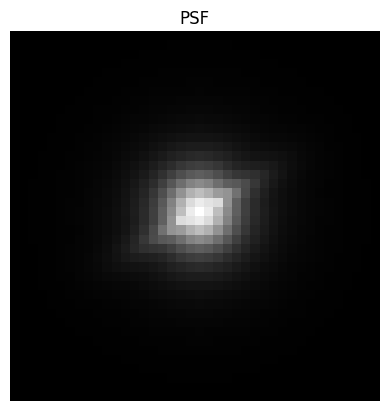

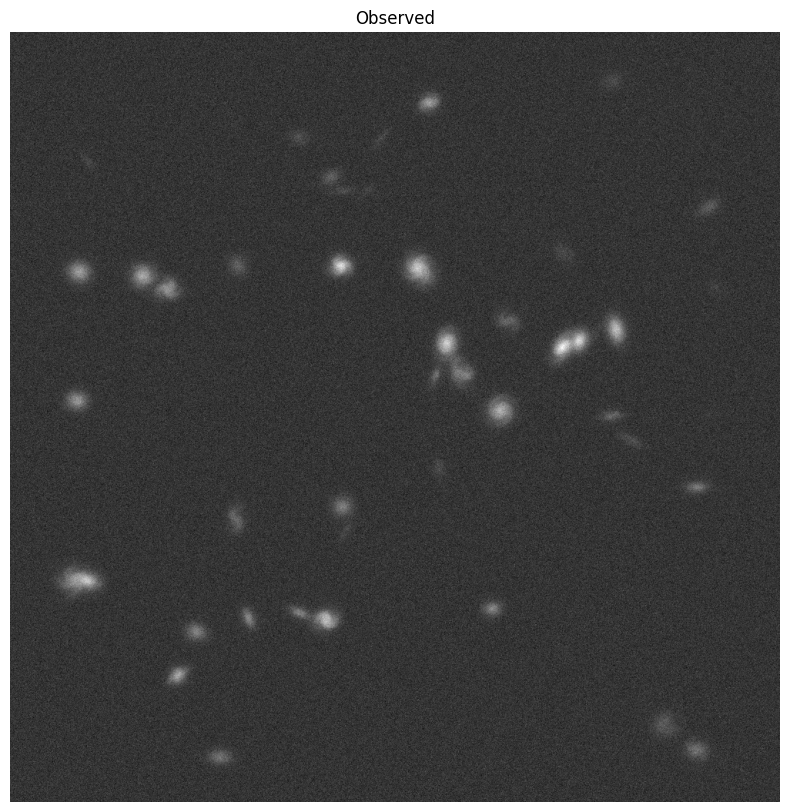

In [514]:
# Define normalized PSF
image_psf = moffat(40, 40, 2, 5, n_spikes=1, rotation=np.pi / 3, spike_strength=0.2, spike_width=0.2, Rc=8)
image_psf /= image_psf.sum()

# Plot PSF
plt.imshow(image_psf)
plt.title("PSF")
plt.show()

# Add noise and convolve with PSF
noise = np.random.normal(0, 0.5, size=image.shape)
new_image = fftconvolve(image, image_psf, mode='same') + noise

# Plot convolved image with noise
plt.figure(figsize=(10, 10))
plt.imshow(new_image)
plt.title("Observed")
plt.show()

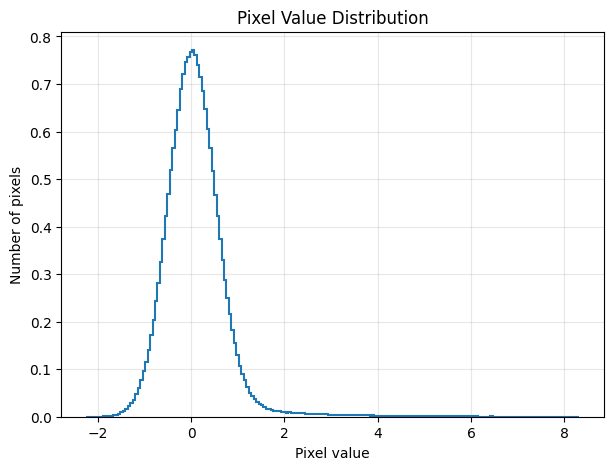

In [490]:
pixels = new_image.flatten()
# Make the histogram
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    plt.figure(figsize=(7, 5))
    plt.hist(pixels, bins=200, histtype='step', lw=1.5, density=True)
    # plt.hist(noise.flatten(), bins=200, histtype='step', lw=1.5, density=True)
    plt.xlabel("Pixel value")
    plt.ylabel("Number of pixels")
    plt.title("Pixel Value Distribution")
    plt.grid(True, alpha=0.3)
    plt.show()


In [499]:
low, high = np.percentile(pixels, [0, 99])  # keep central 98%
pixels_clipped = pixels[pixels<1.08]

mu, sigma = norm.fit(pixels_clipped)

print(f"Estimated mean (background): {mu:.4f}")
print(f"Estimated sigma (noise std): {sigma:.4f}")
print(f"Estimated variance: {sigma**2:.4f}")

Estimated mean (background): 0.0004
Estimated sigma (noise std): 0.4819
Estimated variance: 0.2322


In [509]:
# Calculate rescaled weight
weight = gaussian_weight(height, width, height / 2, width / 2, a, b)
weight_rescale = wiener_deconvolution(weight, image_psf, 0)
cy, cx = np.array(weight_rescale.shape) / 2

measured_F = []
for i, (xc, yc) in enumerate(centers):
    # Shift rescaled weight to the center of the galaxy
    translated = shift(weight_rescale, shift=(yc - cy, xc - cx))

    # Calculate the aperture flux using the observed image and rescaled weight function
    measured_F.append(np.sum(translated * new_image))

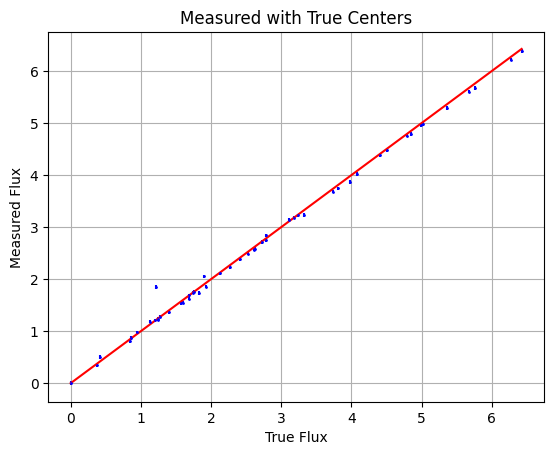

In [510]:
measured_F = np.array(measured_F)
true_F = np.array(true_F)

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Plot measured flux vs true flux
    plt.errorbar(true_F, measured_F, yerr=np.sqrt(np.sum(weight_rescale**2)*sigma**2), label='Measured', c='blue', fmt='o', ms=1)
    plt.plot(np.linspace(0, max(true_F), 10), np.linspace(0, max(true_F), 10), c='red', label='True')

    plt.title("Measured with True Centers")
    plt.xlabel('True Flux')
    plt.ylabel('Measured Flux')
    plt.show()


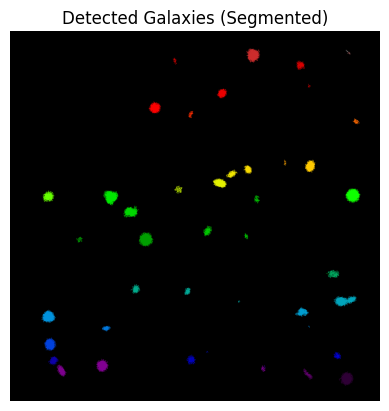

In [452]:
# Determine threshold
threshold = detect_threshold(new_image, nsigma=3.0)

# Detect sources
segm = detect_sources(new_image, threshold, npixels=8)

# Plot segmentation map
plt.imshow(segm.data, origin='lower', cmap='nipy_spectral')
plt.title("Detected Galaxies (Segmented)")
plt.show()

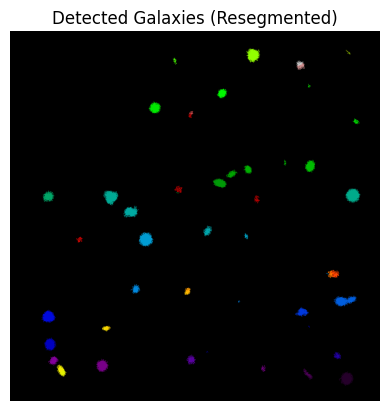

In [454]:
# Deblend sources
segm_deblend = deblend_sources(new_image, segm,
                               npixels=8, nlevels=64, contrast=0.3,
                               progress_bar=False)

# Plot segmentation map
plt.imshow(segm_deblend.data, origin='lower', cmap='nipy_spectral')
plt.title("Detected Galaxies (Resegmented)")
plt.show()

In [455]:
centers_new = []
for label in segm_deblend.labels:
    mask = segm_deblend.data == label
    # Calculate the center of the galaxy from segmentation
    xc, yc = centroid_com(image * mask)
    centers_new.append((xc, yc))

print(f"Number of galaxies {len(segm_deblend.labels)}/{N_galaxies}")

Number of galaxies 58/50


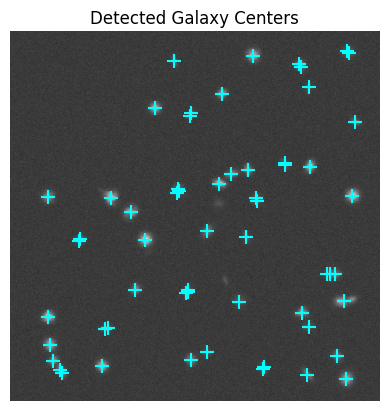

In [456]:
plt.imshow(new_image, origin='lower', cmap='gray')

# Plot detected centers
for (xc, yc) in centers_new:
    plt.scatter(xc, yc, color='cyan', marker='+', s=100)

plt.title("Detected Galaxy Centers")
plt.show()

In [457]:
# Calculate rescaled weight
weight = gaussian_weight(height, width, height / 2, width / 2, a, b)
weight_rescale = wiener_deconvolution(weight, image_psf, 0)
cy, cx = np.array(weight_rescale.shape) / 2

measured_F_new = []
for i, (xc, yc) in enumerate(centers_new):
    # Shift rescaled weight to the center of the galaxy
    translated = shift(weight_rescale, shift=(yc - cy, xc - cx))
    measured_F_new.append(np.sum(translated * new_image))

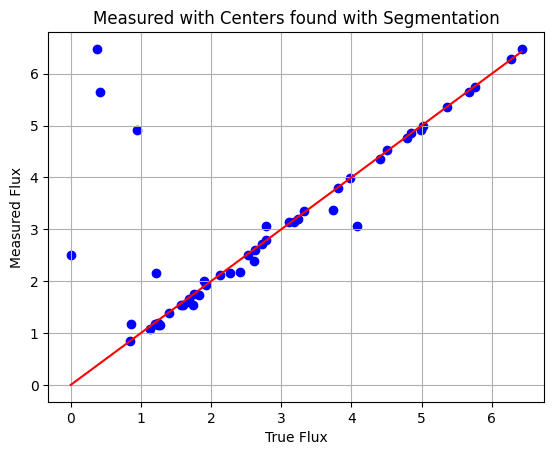

In [467]:
# Find closest centers to true centers
tree = cKDTree(centers_new)
_, indices = tree.query(centers, k=1)

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    for i in range(len(centers)):
        plt.scatter(true_F[i], measured_F_new[indices[i]], label='Measured', c='blue')
    plt.plot([0, max(true_F)], [0, max(true_F)], c='red', label='True')
    plt.title("Measured with Centers found with Segmentation")
    plt.xlabel('True Flux')
    plt.ylabel('Measured Flux')
    plt.show()